# Tutorial 4: Stereo-seq mouse olfactory bulb

This tutorial demonstrates how to identify spatial domains on Stereo-seq data.

In this tutorial, we foucs on the Stereo-seq mouse olfactory bulb data (https://github.com/JinmiaoChenLab/SEDR_analyses/).

We removed spots outside the main tissue area, and the used spots can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import torch

In [3]:
import STAGATE_pyG as STAGATE

In [4]:
data_path = '/home/lytq/Spatial-Transcriptomics-Benchmark/data/Mouse_Olfactory_Bulb/'
save_path = '/home/lytq/Spatial-Transcriptomics-Benchmark/Results/results3/Mouse_Olfactory_Bulb/STAGATE/'

os.makedirs(save_path, exist_ok=True)

In [5]:
counts_file = os.path.join(data_path, 'RNA_counts.tsv.gz')
coor_file = os.path.join(data_path, 'position.tsv')

In [6]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')
print(counts.shape, coor_df.shape)

(27106, 19527) (19527, 3)


In [7]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

In [8]:
coor_df.head()

,x,y
label,,
Spot_1,12555.007833,6307.537859
Spot_2,12623.666667,6297.166667
Spot_3,12589.567164,6302.552239
Spot_4,12642.495050,6307.386139
Spot_5,13003.333333,6307.990991


In [9]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()

In [10]:
adata

AnnData object with n_obs × n_vars = 19527 × 27106

In [11]:
coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obsm["spatial"] = coor_df.to_numpy()
sc.pp.calculate_qc_metrics(adata, inplace=True)

(6002.432692307692, 12486.580128205129, 9908.545833333334, 15086.093055555555)

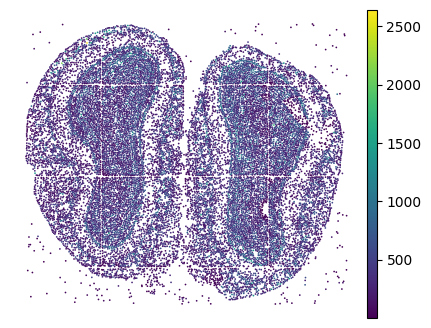

In [12]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [13]:
used_barcode = pd.read_csv(os.path.join(data_path, 'used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]

In [14]:
adata

View of AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

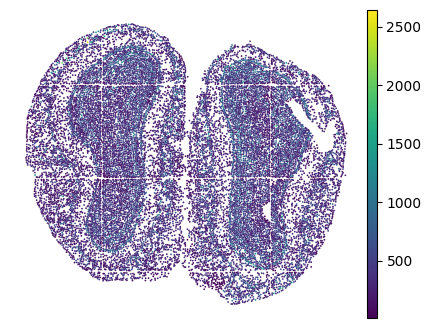

In [15]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [16]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

After flitering:  (19109, 14376)


In [17]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.


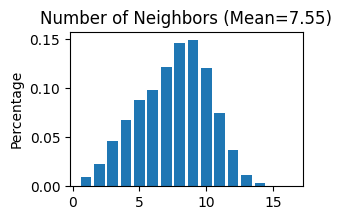

In [18]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=50)
STAGATE.Stats_Spatial_Net(adata)

## Running STAGATE

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
adata = STAGATE.train_STAGATE(adata, device=device)

Size of Input:  (19109, 3000)


100%|██████████| 1000/1000 [00:30<00:00, 32.71it/s]


In [20]:
adata

AnnData object with n_obs × n_vars = 19109 × 14376
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'

In [21]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [22]:
n_clusters = 7
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=n_clusters)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [23]:
sc.tl.louvain(adata, resolution=0.8)

In [24]:
adata

AnnData object with n_obs × n_vars = 19109 × 14376
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mclust', 'louvain'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'Spatial_Net', 'neighbors', 'umap', 'louvain'
    obsm: 'spatial', 'STAGATE', 'X_umap'
    obsp: 'distances', 'connectivities'

In [25]:
save_path

'/home/lytq/Spatial-Transcriptomics-Benchmark/Results/results3/Mouse_Olfactory_Bulb/STAGATE/'

(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

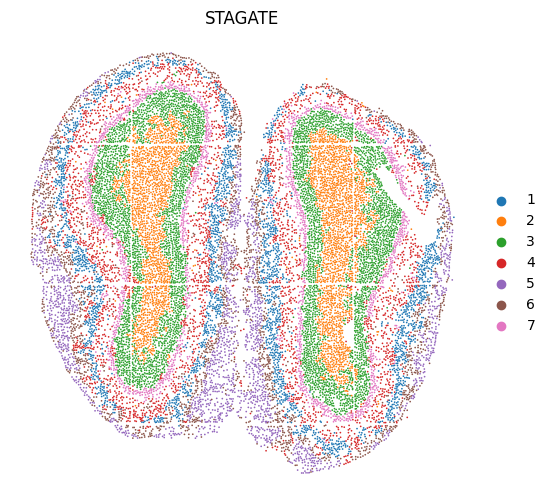

In [26]:
# plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.embedding(adata, basis="spatial", color="mclust",s=6, show=False, title='STAGATE', ax=ax)
plt.axis('off')
# plt.savefig(os.path.join(save_path, 'clustering.pdf'), dpi=300, bbox_inches='tight')

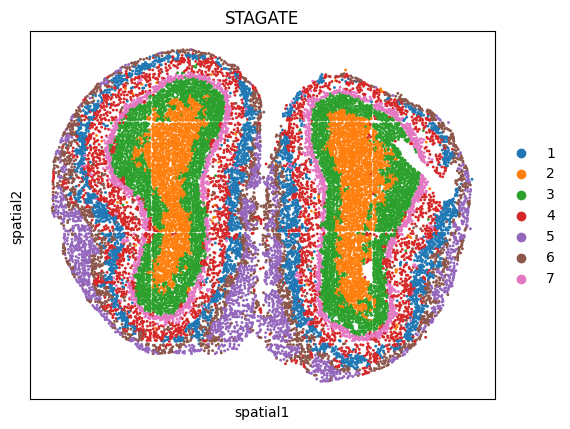

In [29]:
# plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata, color="mclust", show=False, title='STAGATE', ax=ax, spot_size=40)
ax.invert_yaxis()
# plt.axis('off')
plt.savefig(os.path.join(save_path, 'clustering.pdf'), dpi=300, bbox_inches='tight')

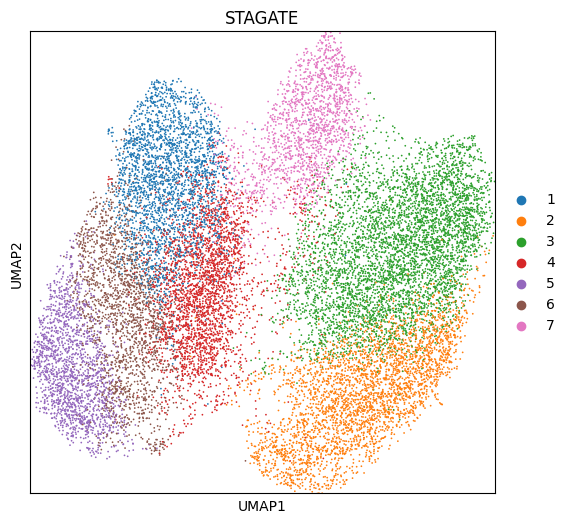

In [30]:
# plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.umap(adata, color='mclust', title='STAGATE', ax=ax, show=False)

# Set axis limits
ax.set_xlim([adata.obsm['X_umap'][:, 0].min(), adata.obsm['X_umap'][:, 0].max()])
ax.set_ylim([adata.obsm['X_umap'][:, 1].min(), adata.obsm['X_umap'][:, 1].max()])

plt.savefig(os.path.join(save_path, 'umap.pdf'), dpi=300, bbox_inches='tight')

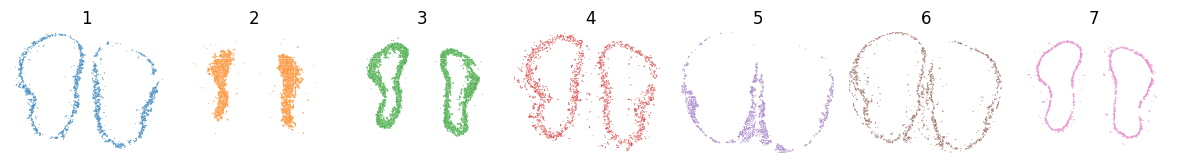

In [31]:
fig, axes = plt.subplots(1,n_clusters,figsize=(1.7*n_clusters, 1.5*2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_clusters):
    sub = adata[adata.obs['mclust'] == i+1]
    sc.pl.spatial(sub, spot_size=30, color='mclust', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i+1)


xmin = adata.obsm['spatial'][:, 0].min()
xmax = adata.obsm['spatial'][:, 0].max()
ymin = adata.obsm['spatial'][:, 1].min()
ymax = adata.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'each_cluster.pdf'), dpi=300, bbox_inches='tight')

In [32]:
adata.obs['x'] = coor_df['x']
adata.obs['y'] = coor_df['y']
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mclust,louvain,x,y
Spot_1,428,6.061457,490.842603,6.198159,21.799249,33.176135,53.549264,100.0,5,2,12555.007833,6307.537859
Spot_10,209,5.347108,240.722222,5.487789,33.948765,54.719594,96.261251,100.0,6,2,12806.715054,6311.983871
Spot_100,153,5.036953,189.000000,5.247024,45.502646,71.957672,100.000000,100.0,5,2,12752.469565,6425.617391
Spot_1000,177,5.181784,212.833333,5.365197,40.328896,63.821457,100.000000,100.0,6,0,12545.601942,6856.786408
Spot_10000,332,5.808142,386.515152,5.959755,27.040376,39.976480,65.848687,100.0,5,2,12993.429134,9153.204724
...,...,...,...,...,...,...,...,...,...,...,...,...
Spot_9994,275,5.620401,325.076923,5.787133,30.785613,46.166588,76.928538,100.0,6,0,14127.819588,9148.005155
Spot_9995,208,5.342334,261.500000,5.570251,39.579350,58.699809,96.940727,100.0,5,2,12933.872611,9147.484076
Spot_9996,334,5.814131,388.083333,5.963794,26.733949,39.703672,65.471333,100.0,5,2,13328.963303,9155.389908
Spot_9998,122,4.812184,136.833333,4.926045,47.381242,83.922046,100.000000,100.0,6,2,12637.854167,9150.281250


In [33]:
cell_metadata = adata.obs
cell_metadata

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mclust,louvain,x,y
Spot_1,428,6.061457,490.842603,6.198159,21.799249,33.176135,53.549264,100.0,5,2,12555.007833,6307.537859
Spot_10,209,5.347108,240.722222,5.487789,33.948765,54.719594,96.261251,100.0,6,2,12806.715054,6311.983871
Spot_100,153,5.036953,189.000000,5.247024,45.502646,71.957672,100.000000,100.0,5,2,12752.469565,6425.617391
Spot_1000,177,5.181784,212.833333,5.365197,40.328896,63.821457,100.000000,100.0,6,0,12545.601942,6856.786408
Spot_10000,332,5.808142,386.515152,5.959755,27.040376,39.976480,65.848687,100.0,5,2,12993.429134,9153.204724
...,...,...,...,...,...,...,...,...,...,...,...,...
Spot_9994,275,5.620401,325.076923,5.787133,30.785613,46.166588,76.928538,100.0,6,0,14127.819588,9148.005155
Spot_9995,208,5.342334,261.500000,5.570251,39.579350,58.699809,96.940727,100.0,5,2,12933.872611,9147.484076
Spot_9996,334,5.814131,388.083333,5.963794,26.733949,39.703672,65.471333,100.0,5,2,13328.963303,9155.389908
Spot_9998,122,4.812184,136.833333,4.926045,47.381242,83.922046,100.000000,100.0,6,2,12637.854167,9150.281250


In [34]:
cell_metadata.to_csv(os.path.join(save_path, 'cell_metadata.csv'))

## SCANPY results (for comparison)

In [35]:
# sc.pp.pca(adata, n_comps=30)

In [36]:
# sc.pp.neighbors(adata, use_rep='X_pca')
# sc.tl.louvain(adata, resolution=0.8)
# sc.tl.umap(adata)

In [37]:
# plt.rcParams["figure.figsize"] = (3, 3)
# sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='SCANPY')
# plt.axis('off')

In [38]:
# sc.pl.umap(adata, color='louvain', title='SCANPY')